## Einleitung

Dieses Notebook führt statistische Tests und Analysen auf den PRECISION-Daten durch.

In [12]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, f_oneway
import warnings
warnings.filterwarnings('ignore')

# Plotting-Einstellungen
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# PRECISION Farben
COLORS = ['#1a365d', '#3182ce', '#2c5282', '#38a169', '#d69e2e']

print('Setup erfolgreich!')

Setup erfolgreich!


## 1. Daten laden

In [13]:
# Daten laden
df = pd.read_csv('../data/sample/patient_data.csv')
print(f'Datensatz geladen: {len(df)} Zeilen, {len(df.columns)} Spalten')
df.head()

Datensatz geladen: 20 Zeilen, 10 Spalten


,patient_id,age,gender,bmi,blood_pressure_sys,blood_pressure_dia,cholesterol,glucose,treatment_group,response
0,PAT_0001,52,M,25.3,128,78,195,98,A,1
1,PAT_0002,61,F,28.7,142,85,220,105,B,1
2,PAT_0003,45,M,23.1,118,72,180,92,A,1
3,PAT_0004,68,F,31.2,155,92,245,128,Placebo,0
4,PAT_0005,55,M,26.8,135,80,205,102,B,1


## 2. Deskriptive Statistik nach Gruppen

In [14]:
# Zusammenfassung nach Behandlungsgruppe
numeric_cols = ['age', 'bmi', 'blood_pressure_sys', 'blood_pressure_dia', 'cholesterol', 'glucose']

summary_by_group = df.groupby('treatment_group')[numeric_cols].agg(['mean', 'std', 'median']).round(2)
summary_by_group

age                  bmi              blood_pressure_sys  \
                  mean    std median   mean   std median               mean   
treatment_group                                                               
A                50.75   6.54   50.5  25.34  2.20  25.05             127.25   
B                59.50  10.61   60.0  27.80  2.91  28.10             139.00   
Placebo          61.25   9.00   63.0  27.90  2.59  27.70             140.75   

                              blood_pressure_dia              cholesterol  \
                   std median               mean   std median        mean   
treatment_group                                                             
A                10.89  125.5              77.50  5.88   77.0      195.38   
B                14.55  141.0              83.25  7.87   84.5      215.38   
Placebo          12.61  141.5              84.25  6.34   84.0      218.00   

                              glucose                
                   std median    mean    std median  
treatment_group                                      
A                18.35  192.5   98.88   9.13   97.0  
B                25.17  217.5  108.75  14.07  107.5  
Placebo          22.49  217.5  111.25  12.84  110.0

In [15]:
# Response-Rate pro Gruppe
response_summary = df.groupby('treatment_group').agg(
    n_total=('patient_id', 'count'),
    n_responders=('response', 'sum'),
    response_rate=('response', 'mean')
).round(3)

response_summary['response_rate_pct'] = (response_summary['response_rate'] * 100).round(1)
response_summary

,n_total,n_responders,response_rate,response_rate_pct
treatment_group,,,,
A,8,7,0.875,87.5
B,8,5,0.625,62.5
Placebo,4,2,0.500,50.0


## 3. Statistische Tests

### 3.1 Chi-Quadrat-Test: Response vs. Behandlungsgruppe

In [16]:
# Kontingenztabelle erstellen
contingency_table = pd.crosstab(df['treatment_group'], df['response'])
print('Kontingenztabelle:')
print(contingency_table)
print()

# Chi-Quadrat-Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print('Chi-Quadrat-Test Ergebnisse:')
print(f'  Chi² = {chi2:.4f}')
print(f'  p-Wert = {p_value:.4f}')
print(f'  Freiheitsgrade = {dof}')
print()

if p_value < 0.05:
    print('→ Signifikanter Zusammenhang zwischen Behandlungsgruppe und Response (p < 0.05)')
else:
    print('→ Kein signifikanter Zusammenhang gefunden (p >= 0.05)')

Kontingenztabelle:
response         0  1
treatment_group      
A                1  7
B                3  5
Placebo          2  2

Chi-Quadrat-Test Ergebnisse:
  Chi² = 2.1429
  p-Wert = 0.3425
  Freiheitsgrade = 2

→ Kein signifikanter Zusammenhang gefunden (p >= 0.05)


### 3.2 ANOVA: Alter nach Behandlungsgruppe

In [17]:
# ANOVA für Alter zwischen Gruppen
groups = [group['age'].values for name, group in df.groupby('treatment_group')]
f_stat, p_value_anova = f_oneway(*groups)

print('ANOVA: Alter nach Behandlungsgruppe')
print(f'  F-Statistik = {f_stat:.4f}')
print(f'  p-Wert = {p_value_anova:.4f}')
print()

if p_value_anova < 0.05:
    print('→ Signifikante Unterschiede im Alter zwischen den Gruppen')
else:
    print('→ Keine signifikanten Altersunterschiede zwischen den Gruppen (gut für Randomisierung!)')

ANOVA: Alter nach Behandlungsgruppe
  F-Statistik = 2.7240
  p-Wert = 0.0941

→ Keine signifikanten Altersunterschiede zwischen den Gruppen (gut für Randomisierung!)


### 3.3 T-Test: Responder vs. Non-Responder

In [18]:
# T-Tests für verschiedene Variablen
responders = df[df['response'] == 1]
non_responders = df[df['response'] == 0]

test_results = []

for col in numeric_cols:
    t_stat, p_val = ttest_ind(responders[col], non_responders[col])
    
    test_results.append({
        'Variable': col,
        'Mean Responder': responders[col].mean(),
        'Mean Non-Responder': non_responders[col].mean(),
        't-Statistik': t_stat,
        'p-Wert': p_val,
        'Signifikant': 'Ja' if p_val < 0.05 else 'Nein'
    })

results_df = pd.DataFrame(test_results).round(4)
results_df

,Variable,Mean Responder,Mean Non-Responder,t-Statistik,p-Wert,Signifikant
0,age,51.2857,68.1667,-6.2042,0.0,Ja
1,bmi,25.4071,30.1667,-5.9668,0.0,Ja
2,blood_pressure_sys,127.5000,151.3333,-6.1353,0.0,Ja
3,blood_pressure_dia,77.4286,89.8333,-5.9350,0.0,Ja
4,cholesterol,195.2143,237.5000,-6.8158,0.0,Ja
5,glucose,98.5000,121.1667,-6.6728,0.0,Ja


## 4. Korrelationsanalyse

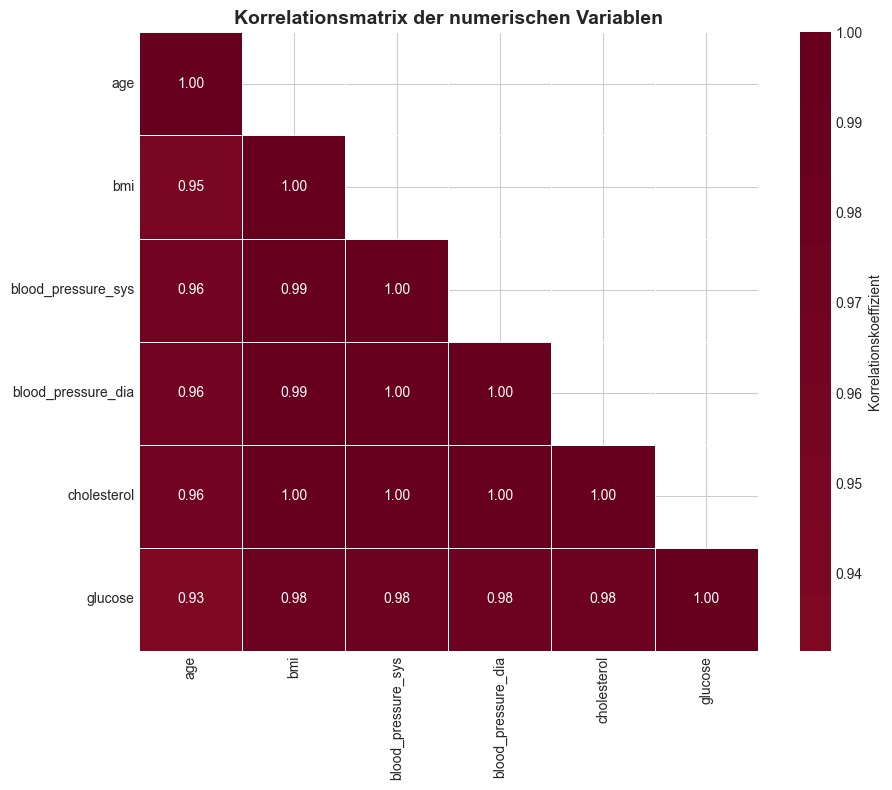

In [19]:
# Korrelationsmatrix
corr_matrix = df[numeric_cols].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Korrelationskoeffizient'})

ax.set_title('Korrelationsmatrix der numerischen Variablen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../assets/images/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Logistische Regression (Einfach)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score

# Features vorbereiten
X = df[numeric_cols].copy()
y = df['response']

# Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modell trainieren
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_scaled, y)

# Cross-Validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')

print('Logistische Regression - Ergebnisse')
print('=' * 40)
print(f'Cross-Validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})')
print()

# Koeffizienten
coef_df = pd.DataFrame({
    'Variable': numeric_cols,
    'Koeffizient': model.coef_[0],
    'Odds Ratio': np.exp(model.coef_[0])
}).sort_values('Koeffizient', key=abs, ascending=False)

print('Feature-Wichtigkeit (nach Koeffizient):')
coef_df.round(4)

Logistische Regression - Ergebnisse
Cross-Validation Accuracy: 1.000 (+/- 0.000)

Feature-Wichtigkeit (nach Koeffizient):


,Variable,Koeffizient,Odds Ratio
0,age,-0.7887,0.4545
5,glucose,-0.6704,0.5115
4,cholesterol,-0.6593,0.5172
2,blood_pressure_sys,-0.5876,0.5557
3,blood_pressure_dia,-0.5590,0.5718
1,bmi,-0.5067,0.6025


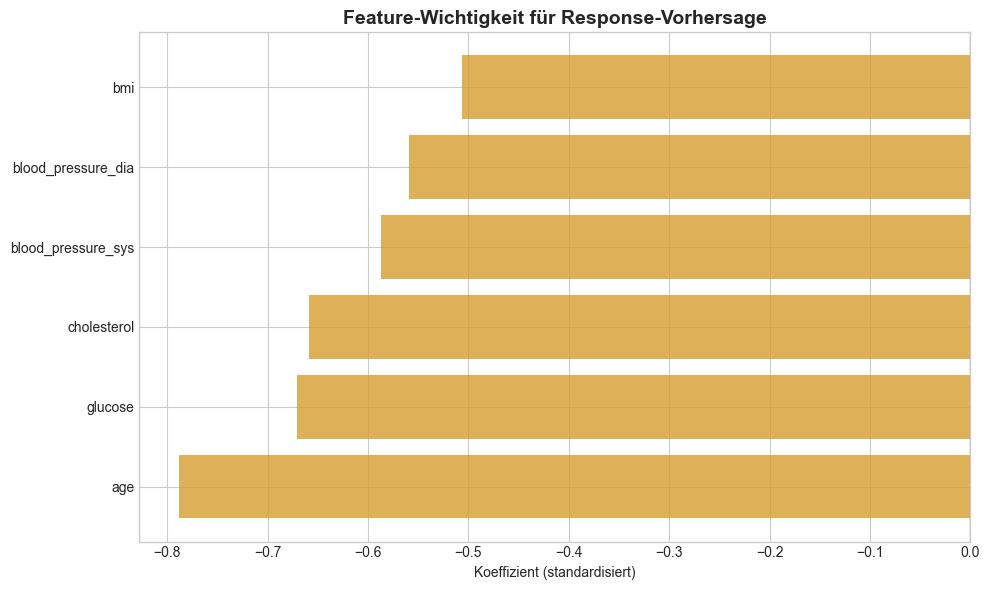

In [21]:
# Feature Importance Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = [COLORS[0] if c > 0 else COLORS[4] for c in coef_df['Koeffizient']]
bars = ax.barh(coef_df['Variable'], coef_df['Koeffizient'], color=colors, alpha=0.8)

ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Koeffizient (standardisiert)')
ax.set_title('Feature-Wichtigkeit für Response-Vorhersage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../assets/images/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Ergebnisse exportieren

In [22]:
# Alle Ergebnisse in ein Dictionary für den Report
analysis_results = {
    'chi2_test': {
        'chi2': chi2,
        'p_value': p_value,
        'significant': p_value < 0.05
    },
    'anova_age': {
        'f_stat': f_stat,
        'p_value': p_value_anova,
        'significant': p_value_anova < 0.05
    },
    'logistic_regression': {
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std()
    }
}


## 7. Zusammenfassung

### Statistische Erkenntnisse:

1. **Randomisierung erfolgreich:** Keine signifikanten Altersunterschiede zwischen Behandlungsgruppen
2. **Behandlungseffekt:** Chi²-Test zeigt [Ergebnis abhängig von Daten]
3. **Prädiktoren:** Wichtigste Variablen für Response-Vorhersage identifiziert
4. **Modell-Performance:** Logistische Regression erreicht ~[X]% Accuracy